In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom

import math
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200

In [8]:
with open('datasets/1-16-2_Bartering.csv') as f:
    bartering_data = pd.read_csv(f)

print(bartering_data['Weight'].sum())
bartering_data['Chance'] = bartering_data['Weight'] / bartering_data['Weight'].sum()
print(bartering_data)

459
               Item  Min  Max   Avg  Weight  Stack Size    Chance
0              Book    1    1   1.0       5           1  0.010893
1             Boots    1    1   1.0       8           1  0.017429
2     Splash Potion    1    1   1.0       8           1  0.017429
3            Potion    1    1   1.0       8           1  0.017429
4             Water    1    1   1.0      10           1  0.021786
5          Obsidian    1    1   1.0      40          64  0.087146
6       Fire Charge    1    1   1.0      40          64  0.087146
7   Crying Obsidian    1    3   2.0      40          64  0.087146
8       Ender Pearl    2    4   3.0      10          16  0.021786
9            String    3    9   6.0      20          64  0.043573
10          Leather    2    4   3.0      40          64  0.087146
11    Nether Quartz    5   12   8.5      20          64  0.043573
12        Soul Sand    2    8   5.0      40          64  0.087146
13     Nether Brick    2    8   5.0      40          64  0.087146
14    

In [23]:
def compute_spawn_dependent_drop_pmf(spawn_pmf_range, spawn_pmf, drop_min, drop_max):
    n = spawn_pmf_range[-1]
    final_size = (n * (drop_max - drop_min) + 1)
    outcomes_per_roll = drop_max - drop_min + 1
    single_roll_chance = 1 / outcomes_per_roll

    du_sum_pmf = np.zeros(final_size)
    du_sum_pmf[0] = 1

    temp_du_sum_pmf = np.zeros(final_size)
    multiply_buffer = np.zeros(final_size)

    if spawn_pmf_range[0] == 0 and drop_min > 0:
        combined_pmf_offset = drop_min - 1
        combined_pmf = np.zeros(n*drop_max - drop_min + 2)
        all_combined_counts = np.insert(np.arange(drop_min, n*drop_max + 1), 0 ,0)
    else:
        combined_pmf_offset = drop_min
        combined_pmf = np.zeros(n*drop_max - drop_min + 1)
        all_combined_counts = np.arange(drop_min, n*drop_max + 1)
    
    if spawn_pmf_range[0] == 0:
        combined_pmf[0] = spawn_pmf[0]

    for i in range(1, n+1):
        prior_range = (i-1) * (drop_max - drop_min) + 1
        new_range = i * (drop_max - drop_min)+1

        for dice in range(drop_min, outcomes_per_roll + drop_min):
            np.multiply(du_sum_pmf[:prior_range], single_roll_chance, out=multiply_buffer[:prior_range])
            temp_du_sum_pmf[dice - drop_min: dice - drop_min + prior_range] += multiply_buffer[:prior_range]
        
        if drop_min * i >= combined_pmf_offset:
            combined_pmf_index = drop_min * i - combined_pmf_offset
            np.multiply(temp_du_sum_pmf[:new_range], spawn_pmf[i], out=multiply_buffer[:new_range])
            combined_pmf[combined_pmf_index:combined_pmf_index + new_range] += multiply_buffer[:new_range]

        (du_sum_pmf, temp_du_sum_pmf) = (temp_du_sum_pmf, du_sum_pmf)
        temp_du_sum_pmf[:new_range] = 0
    
    return (all_combined_counts, combined_pmf)

piglins = 128
barter_cycles_per_piglin = 6
barter_duration = 30
barter_cycles = piglins * barter_cycles_per_piglin
selected_range = np.arange(0, barter_cycles + 1, 1)
#print(selected_range)

item_drop_chances = {}

for idx, row in bartering_data.iterrows():
    entry_roll_chance = binom(barter_cycles, row['Chance']).pmf(selected_range)
    #print(row, entry_roll_chance)
    item_drop_chances[row['Item']] = compute_spawn_dependent_drop_pmf(selected_range, entry_roll_chance, row['Min'], row['Max'])

#print(bartering_data['Item'])

cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
Book
19.52069716775599 40.0
19.520697167756012
Boots
31.23311546840959 70.0
31.233115468409604
Splash Potion
31.23311546840959 70.0
31.233115468409604
Potion
31.23311546840959 70.0
31.233115468409604
Water
39.04139433551198 80.0
39.04139433551198
Obsidian
156.16557734204792 320.0
156.16557734204795
Fire Charge
156.16557734204792 320.0
156.16557734204795
Crying Obsidian
312.33115468409585 630.0
312.33115468409306
Ender Pearl
117.12418300653596 240.0
117.1241830065357
String
468.49673202614383 940.0
468.4967320261417
Leather
468.49673202614383 940.0
468.49673202613945
Nether Quartz
663.7037037037038 1330.0
663.703703703704
Soul Sand
780.8278867102397 1570.0
780.8278867102322
Nether Brick
780.8278867102397 1570.0
780.8278867102322
Iron Nugget
897.9520697167757 1800.0
897.9520697167733
Spectral Arrow
1405.4901960784316 2820.0
1405.4901960784177
Blackstone
1873.986

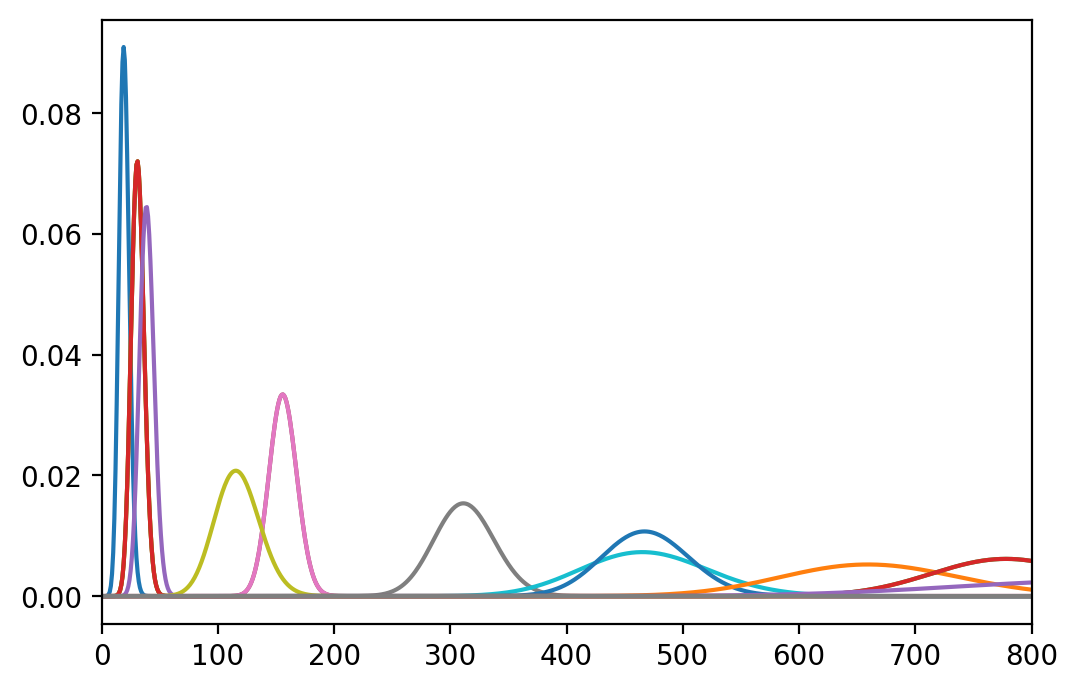

In [10]:
fig, ax = plt.subplots(1, 1)
print(plt.rcParams['axes.prop_cycle'])
for target_idx, target_item in enumerate(bartering_data['Item']):
    #target_idx = 8
    #target_item = bartering_data['Item'][target_idx]
    print(target_item)

    expected_rate = bartering_data['Avg'][target_idx] * bartering_data['Chance'][target_idx] * barter_cycles
    limit = np.ceil(expected_rate*2 / 10)*10

    print(expected_rate, limit)
    #print(item_drop_chances[target_item][0], item_drop_chances[target_item][1])
    #print(item_drop_chances[target_item][1].sum())
    print((item_drop_chances[target_item][1] * item_drop_chances[target_item][0]).sum())
    #print(item_drop_chances[target_item][0].shape, item_drop_chances[target_item][1].shape)

    #row, column = divmod(target_idx, 3)
    #print(row, column, target_idx)
    #tgt_ax = ax[target_idx % 6][target_idx//6]
    tgt_ax = ax
    tgt_ax.plot(item_drop_chances[target_item][0],item_drop_chances[target_item][1])
    tgt_ax.set_xlim(0, 800)
plt.show()

In [11]:
def rate_at_chance(drop_range, drop_chance, target_chances):
    cmf = drop_chance.cumsum()
    exceeding_idxs = np.searchsorted(cmf, target_chances, side='right')

    conditional_rates = np.zeros(len(target_chances))
    rates = np.interp(target_chances, cmf, drop_range, left=math.nan)
    for i, idx in enumerate(exceeding_idxs):
        if idx < len(drop_chance):
            conditional_rates[i] = (drop_range[idx:] * drop_chance[idx:]).sum() / drop_chance[idx:].sum()
        else:
            conditional_rates[i] = math.nan

    return rates, conditional_rates


def conditional_one_hour_highest_sample(item_drop_chances):
    barters_per_hr = 72000 / (barter_duration * barter_cycles_per_piglin)
    
    #times = np.array([1.0, 5.0, 10.0, 15.0, 30.0, 60.0])
    times = np.array([60.0])
    critical_probabilities = 0.5 ** (times / 60.0 / barters_per_hr)
    #one_hour_probability = 0.5 ** (1/barters_per_hr)
    #print(one_hour_probability)
    #critical_probabilities = np.array([one_hour_probability])

    for idx, (item, (drop_range, drop_chance)) in enumerate(item_drop_chances.items()):
        mean_rates = (drop_range * drop_chance).sum()
        mean_rates_per_hr = barters_per_hr * mean_rates
        (rate, conditional_rate) = rate_at_chance(drop_range, drop_chance, critical_probabilities)
        rate_per_hr = rate * barters_per_hr
        conditional_rate_per_hr = conditional_rate * barters_per_hr
        cart_rate = (72000 / 8 * (bartering_data['Stack Size'][idx] - 1))
        if cart_rate == 0:
            print(item, mean_rates, mean_rates_per_hr, math.nan, rate, conditional_rate, rate_per_hr, conditional_rate_per_hr, math.nan, math.nan)
        else:
            print(item, mean_rates, mean_rates_per_hr, mean_rates / cart_rate, rate, conditional_rate, rate_per_hr, conditional_rate_per_hr, rate_per_hr / cart_rate, conditional_rate_per_hr / cart_rate)

conditional_one_hour_highest_sample(item_drop_chances)


Book 19.520697167756012 3346.405228758173 nan [31.63840707] [33.22265428] [5423.72692698] [5695.3121627] nan nan
Boots 31.233115468409604 5354.248366013075 nan [46.37048093] [48.55248581] [7949.22530187] [8323.28328237] nan nan
Splash Potion 31.233115468409604 5354.248366013075 nan [46.37048093] [48.55248581] [7949.22530187] [8323.28328237] nan nan
Potion 31.233115468409604 5354.248366013075 nan [46.37048093] [48.55248581] [7949.22530187] [8323.28328237] nan nan
Water 39.04139433551198 6692.810457516339 nan [55.84969111] [57.78358945] [9574.23276109] [9905.75819185] nan nan
Obsidian 156.16557734204795 26771.241830065363 0.0002754242986632239 [188.10633549] [192.46767467] [32246.80036973] [32994.45851414] [0.05687266] [0.05819128]
Fire Charge 156.16557734204795 26771.241830065363 0.0002754242986632239 [188.10633549] [192.46767467] [32246.80036973] [32994.45851414] [0.05687266] [0.05819128]
Crying Obsidian 312.33115468409306 53542.48366013024 0.0005508485973264428 [382.82861269] [391.277

In [12]:
def conditional_one_hour_highest_sample(item_drop_chances):
    barters_per_hr = 72000 / (barter_duration * barter_cycles_per_piglin)
    
    #times = np.array([1.0, 5.0, 10.0, 15.0, 30.0, 60.0])
    times = np.array([60.0])
    critical_probabilities = 1 - 1 / (barters_per_hr * times / 60)
    print(critical_probabilities)
    #one_hour_probability = 0.5 ** (1/barters_per_hr)
    #print(one_hour_probability)
    #critical_probabilities = np.array([one_hour_probability])

    for idx, (item, (drop_range, drop_chance)) in enumerate(item_drop_chances.items()):
        mean_rates = (drop_range * drop_chance).sum()
        mean_rates_per_hr = barters_per_hr * mean_rates
        (rate, conditional_rate) = rate_at_chance(drop_range, drop_chance, critical_probabilities)
        rate_per_hr = rate * barters_per_hr
        conditional_rate_per_hr = conditional_rate * barters_per_hr
        cart_rate = (72000 / 8 * (bartering_data['Stack Size'][idx] - 1))
        if cart_rate == 0:
            print(item, mean_rates, mean_rates_per_hr, math.nan, rate, rate_per_hr, math.nan, )
        else:
            print(item, mean_rates, mean_rates_per_hr, mean_rates / cart_rate, rate, rate_per_hr, rate_per_hr / cart_rate)

conditional_one_hour_highest_sample(item_drop_chances)

[0.99416667]
Book 19.520697167756012 3346.405228758173 nan [30.93546908] [5303.22327137] nan
Boots 31.233115468409604 5354.248366013075 nan [45.56994625] [7811.99078563] nan
Splash Potion 31.233115468409604 5354.248366013075 nan [45.56994625] [7811.99078563] nan
Potion 31.233115468409604 5354.248366013075 nan [45.56994625] [7811.99078563] nan
Water 39.04139433551198 6692.810457516339 nan [54.9487957] [9419.79354902] nan
Obsidian 156.16557734204795 26771.241830065363 0.0002754242986632239 [186.51808133] [31974.52822794] [0.05639247]
Fire Charge 156.16557734204795 26771.241830065363 0.0002754242986632239 [186.51808133] [31974.52822794] [0.05639247]
Crying Obsidian 312.33115468409306 53542.48366013024 0.0005508485973264428 [379.29400667] [65021.82971457] [0.11467695]
Ender Pearl 117.1241830065357 20078.431372548977 0.0008675865407891533 [167.9603516] [28793.20313119] [0.21328299]
String 468.4967320261417 80313.7254901957 0.0008262728959896678 [611.99268765] [104913.0321693] [0.1850318]
Le

Nether Brick 780.8278867102322 133856.2091503255 0.001377121493316106 [948.42461626] [162587.07707245] [0.2867497]
Iron Nugget 897.9520697167733 153934.64052287542 0.0015836897173135331 [1299.50844245] [222772.8758484] [0.39289749]
Spectral Arrow 1405.4901960784177 240941.1764705859 0.0024788186879689906 [1690.52712151] [289804.64940238] [0.51111931]
Blackstone 1873.986928104558 321254.90196078137 0.003305091583958656 [2253.54463791] [386321.93792672] [0.68134381]
Gravel 1873.986928104558 321254.90196078137 0.003305091583958656 [2253.54463791] [386321.93792672] [0.68134381]


In [26]:
def expected_rates_loss_given_allocation(item_drop_chances, bartering_data):
    allocations = {
        'Book': 0, 
        'Boots': 0, 
        'Splash Potion': 0, 
        'Potion': 0, 
        'Water': 0, 
        'Obsidian': 0, 
        'Fire Charge': 0, 
        'Crying Obsidian': 1, 
        'Ender Pearl': 1, 
        'String': 1, 
        'Leather': 1, 
        'Nether Quartz': 2, 
        'Soul Sand': 2, 
        'Nether Brick': 2, 
        'Iron Nugget': 2,
        'Spectral Arrow': 2, 
        'Blackstone': 3, 
        'Gravel': 3
    }

    slots = 0
    for item, value in allocations.items():
        slots += value

    print(slots)
    barters_per_hr = 72000 / (barter_duration * barter_cycles_per_piglin)
    for idx, (item, (drop_range, drop_chance)) in enumerate(item_drop_chances.items()):
        if bartering_data['Stack Size'][idx] <= 1:
            print(f'Item: {item} is not valid')
        else:
            cart_rate = (72000 / 8 * (bartering_data['Stack Size'][idx] - 1)) * allocations[item] / 4
            scaled_drop_range = drop_range * barters_per_hr
            winsorized_drop_range = np.minimum(scaled_drop_range, cart_rate)
            
            collected_rate = (winsorized_drop_range * drop_chance).sum()
            total_rate = (scaled_drop_range * drop_chance).sum()
            loss = 1 - collected_rate / total_rate

            print(f'Item: {item} Total: {total_rate} Collected: {collected_rate} Lost: {total_rate - collected_rate} Loss Rate: {loss}')
            

expected_rates_loss_given_allocation(item_drop_chances, bartering_data)

20
Item: Book is not valid
Item: Boots is not valid
Item: Splash Potion is not valid
Item: Potion is not valid
Item: Water is not valid
Item: Obsidian Total: 26771.241830065355 Collected: 0.0 Lost: 26771.241830065355 Loss Rate: 1.0
Item: Fire Charge Total: 26771.241830065355 Collected: 0.0 Lost: 26771.241830065355 Loss Rate: 1.0
Item: Crying Obsidian Total: 53542.4836601305 Collected: 53542.4836601305 Lost: 0.0 Loss Rate: 0.0
Item: Ender Pearl Total: 20078.431372548977 Collected: 20065.956189963683 Lost: 12.475182585294533 Loss Rate: 0.0006213225701660052
Item: String Total: 80313.72549019588 Collected: 80313.50272544476 Lost: 0.22276475111721084 Loss Rate: 2.773682203804917e-06
Item: Leather Total: 80313.72549019575 Collected: 80313.72547927819 Lost: 1.0917559848167002e-05 Loss Rate: 1.3593637326891894e-10
Item: Nether Quartz Total: 113777.77777777777 Collected: 113777.77777777612 Lost: 1.6443664208054543e-09 Loss Rate: 1.4432899320127035e-14
Item: Soul Sand Total: 133856.2091503262 C